# Class Inbalance in Binary Classification  
### Aprendizagem Computacional 1

**João Pedro Nunes Rocha** — up202306599  
**Paulo Diogo Lopes Pinto** — up202306412  
**Rui Filipe Rocha Alvarilhão** — up202209089  

Implementação baseada no algoritmo **XGBoost**, sem modificações para lidar com o desbalanceamento de classes.


# Bibliotecas necessárias

Para executar este código, é necessário instalar as seguintes bibliotecas:

- numpy -> 2.2.3
- pandas -> 2.2.3
- scikit-learn -> 1.6.1
- imbalanced-learn -> 0.13.0
- matplotlib -> 3.10.0
- seaborn -> 0.13.2
- scipy -> 1.15.2

In [1]:
import numpy as np
import os
from scipy.special import expit
import random
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_auc_score,recall_score, f1_score,confusion_matrix,accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math

# XGBoost e Desbalanceamento em Datasets

XGBoost é um poderoso algoritmo de aprendizado baseado em boosting de gradiente, que constrói um modelo forte combinando várias árvores de decisão simples, treinadas iterativamente para corrigir erros anteriores. É muito eficiente para dados tabulares e pode ser usado para regressão e classificação.
**Funcionamento básico:**

   1. Começa com uma previsão inicial simples (média).

   2. Calcula o erro residual entre as previsões e os valores reais.

   3. Treina uma árvore para prever esses erros.

   4. Atualiza as previsões somando a contribuição da nova árvore ponderada pela taxa de aprendizado.

   5. Repete o processo várias vezes, minimizando a função de perda via gradiente descendente.

**Vantagens**

- Alta precisão e robustez.

- Flexível para diferentes tipos de problemas.

- Suporta dados esparsos e valores ausentes.

**Desvantagens**

- Pode ser lento em datasets muito grandes.

- Requer ajuste cuidadoso dos hiperparâmetros.

- Modelo menos interpretável que árvores isoladas.

# Datasets Desbalanceados

Um dataset desbalanceado tem uma distribuição desigual entre classes, onde uma classe é muito mais frequente que a outra. Isso gera desafios como:

- **Previsão enviesada:** o modelo tende a favorecer a classe maioritária.

- **Baixa performance:** na classe minoritária -> alto erro para a classe menos representada.

- **Avaliação complexa:** métricas comuns como acurácia não refletem bem o desempenho; é melhor usar F1-score e G-means.

# Algoritmo

In [5]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

## Tree

In [6]:
def xgb_criterion(y, left, right, loss):
    left = loss.gain(left["actual"], left["y_pred"])
    right = loss.gain(right["actual"], right["y_pred"])
    initial = loss.gain(y["actual"], y["y_pred"])
    gain = left + right - initial
    return gain

In [7]:
def split(X, y, value):
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]

In [8]:
def get_split_mask(X, column, value):
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    return left_mask, right_mask

In [9]:
def split_dataset(X, target, column, value, return_X=True):
    left_mask, right_mask = get_split_mask(X, column, value)

    left, right = {}, {}
    for key in target.keys():
        left[key] = target[key][left_mask]
        right[key] = target[key][right_mask]

    if return_X:
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left, right
    else:
        return left, right

In [10]:
class Tree(object):
    """Recursive implementation of decision tree."""

    def __init__(self, regression=False, criterion=None, n_classes=None):
        self.regression = regression
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome = None
        self.criterion = criterion
        self.loss = None
        self.n_classes = n_classes 

        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, target, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                # Gradient boosting
                left, right = split_dataset(X, target, column, value, return_X=False)
                gain = xgb_criterion(target, left, right, self.loss)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def _train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01):
        try:
            # Exit from recursion using assert syntax
            assert X.shape[0] > min_samples_split
            assert max_depth > 0

            if max_features is None:
                max_features = X.shape[1]

            column, value, gain = self._find_best_split(X, target, max_features)
            assert gain is not None
            if self.regression:
                assert gain != 0
            else:
                assert gain > minimum_gain

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, target, column, value)

            # Grow left and right child
            self.left_child = Tree(self.regression, self.criterion, self.n_classes)
            self.left_child.loss = self.loss
            self.left_child._train(
                left_X, left_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )

            self.right_child = Tree(self.regression, self.criterion, self.n_classes)
            self.right_child.loss = self.loss
            self.right_child._train(
                right_X, right_target, max_features, min_samples_split, max_depth - 1, minimum_gain
            )
            
        except AssertionError:
            self._calculate_leaf_value(target)

    def train(self, X, target, max_features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01, loss=None):
        """Build a decision tree from training set.

        Parameters
        ----------

        X : array-like
            Feature dataset.
        target : dictionary or array-like
            Target values.
        max_features : int or None
            The number of features to consider when looking for the best split.
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the tree.
        minimum_gain : float, default 0.01
            Minimum gain required for splitting.
        loss : function, default None
            Loss function for gradient boosting.
        """

        if not isinstance(target, dict):
            target = {"y": target}

        # Loss for gradient boosting
        if loss is not None:
            self.loss = loss

        if not self.regression:
            self.n_classes = len(np.unique(target['y']))

        self._train(X, target, max_features=max_features, min_samples_split=min_samples_split,
                    max_depth=max_depth, minimum_gain=minimum_gain)


    def _calculate_leaf_value(self, targets):
        """Find optimal value for leaf."""
        # Gradient boosting
        self.outcome = self.loss.approximate(targets["actual"], targets["y_pred"])

    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

## Gradient Boosting

In [11]:
def mse_criterion(y, splits):
    y_mean = np.mean(y)
    return -sum([np.sum((split - y_mean) ** 2) * (float(split.shape[0]) / y.shape[0]) for split in splits])

In [12]:
class Loss:
    """Base class for loss functions."""

    def __init__(self, regularization=1.0):
        self.regularization = regularization

    def approximate(self, actual, predicted):
        """Approximate leaf value."""
        return self.grad(actual, predicted).sum() / (self.hess(actual, predicted).sum() + self.regularization)

    def transform(self, pred):
        """Transform predictions values."""
        return pred

    def gain(self, actual, predicted):
        """Calculate gain for split search."""
        nominator = self.grad(actual, predicted).sum() ** 2
        denominator = self.hess(actual, predicted).sum() + self.regularization
        return 0.5 * (nominator / denominator)

In [13]:
class LogisticLoss(Loss):
    """Logistic loss."""

    def grad(self, actual, predicted):
        return actual * expit (-actual * predicted)

    def hess(self, actual, predicted):
        expits = expit(predicted)
        return expits * (1 - expits)

    def transform(self, output):
        # Apply logistic (sigmoid) function to the output
        return expit(output)


In [14]:
class GradientBoosting(BaseEstimator):
    """Gradient boosting trees with Taylor's expansion approximation (as in xgboost)."""

    def __init__(self, n_estimators, learning_rate=0.1, max_features=10, max_depth=2, min_samples_split=10):
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []
        self.loss = None

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.y_mean = np.mean(y)
        self._train()

    def _train(self):
        # Initialize model with zeros
        #y_pred = np.zeros(self.n_samples, np.float32)
        # Or mean
        y_pred = np.full(self.n_samples, self.y_mean)

        for n in range(self.n_estimators):
            residuals = self.loss.grad(self.y, y_pred)
            tree = Tree(regression=False, criterion=mse_criterion)
            # Pass multiple target values to the tree learner
            targets = {
                # Residual values
                "y": residuals,
                # Actual target values
                "actual": self.y,
                # Predictions from previous step
                "y_pred": y_pred,
            }

            tree.train(
                self.X,
                targets,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                loss=self.loss,
            )
            predictions = tree.predict(self.X)
            y_pred += self.learning_rate * predictions
            self.trees.append(tree)

    def _predict(self, X=None):
        y_pred = np.zeros(X.shape[0], np.float32)

        for i, tree in enumerate(self.trees):
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

    def predict(self, X=None):
        return self.loss.transform(self._predict(X))

In [15]:
class GradientBoostingClassifier(GradientBoosting):
    def fit(self, X, y=None):
        # Convert labels from {0, 1} to {-1, 1}
        y = (y * 2) - 1
        self.loss = LogisticLoss()
        super(GradientBoostingClassifier, self).fit(X, y)

# Learning Curve

In [2]:
def plot_learning_curves(model_class, X, y,train_sizes=np.linspace(0.1, 1.0, 10),title="Learning Curves"):
    """
    Plota as curvas de aprendizagem (learning curves) para vários métricas de avaliação,
    usando diferentes frações do conjunto de treino.

    Parâmetros:
    -----------
    model_class : Algoritemo 
        A classe do modelo a ser instanciada.

    X : ndarray 
        As features dos dados.

    y : ndarray 
        O vetor das classes correspondentes a X.

    train_sizes : array
        Array com frações do conjunto de treino a serem usadas (porcentagens dos dados).

    title : str
        Título base dos gráficos de saída.

    Métricas Avaliadas:
    -------------------
    - accuracy     -> Taxa de acerto
    - f1           -> F1-score
    - roc_auc      -> Área sob a curva ROC
    - recall       -> Sensibilidade (verdadeiros positivos)
    - specificity  -> Especificidade (verdadeiros negativos)
    - gmeans       -> Média geométrica entre recall e especificidade (importante em datasets desbalanceados)

    Funcionamento:
    --------------
    1. Divide o conjunto de dados em treino (70%) e validação (30%).
    2. Para cada fração definida em train_sizes, seleciona os primeiros N exemplos do treino.
    3. Treina um novo modelo com esses exemplos.
    4. Realiza as predições no treino e validação.
    5. Calcula e armazena os valores de todas as métricas definidas.
    6. Gera um gráfico para cada métrica, comparando desempenho no treino e validação.
    """


    metrics = ['accuracy', 'f1', 'roc_auc', 'recall', 'specificity', 'gmeans']

    train_scores = {m: [] for m in metrics}
    val_scores = {m: [] for m in metrics}

    # Split do dataset
    X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.30, random_state=1111)
    n_train_full = X_train_full.shape[0]

    # Loop para todos os train_sizes 
    for frac in train_sizes:
        n = int(n_train_full * frac)
        X_train = X_train_full[:n]
        y_train = y_train_full[:n]

        # Treina o modelo
        model = model_class()
        model.fit(X_train, y_train)

        # Obtem os resultados para a validação e treino
        y_train_pred = (model.predict(X_train) >= 0.5).astype(int)
        y_val_pred = (model.predict(X_val) >= 0.5).astype(int)

        # Faz a confusion matrix 
        tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_train_pred, labels=[0, 1]).ravel()
        tn_va, fp_va, fn_va, tp_va = confusion_matrix(y_val, y_val_pred, labels=[0, 1]).ravel()

        # Cacula cada uma das metricas 
        for m in metrics:
            if m == 'accuracy':
                train_scores[m].append(accuracy_score(y_train, y_train_pred))
                val_scores[m].append(accuracy_score(y_val, y_val_pred))
            elif m == 'f1':
                train_scores[m].append(f1_score(y_train, y_train_pred))
                val_scores[m].append(f1_score(y_val, y_val_pred))
            elif m == 'roc_auc':
                train_scores[m].append(roc_auc_score(y_train, y_train_pred))
                val_scores[m].append(roc_auc_score(y_val, y_val_pred))
            elif m == 'recall':
                train_scores[m].append(recall_score(y_train, y_train_pred))
                val_scores[m].append(recall_score(y_val, y_val_pred))
            elif m == 'specificity':
                train_scores[m].append(tn_tr / (tn_tr + fp_tr))
                val_scores[m].append(tn_va / (tn_va + fp_va))
            elif m == 'gmeans':
                spec_tr = tn_tr / (tn_tr + fp_tr)
                rec_tr = tp_tr / (tp_tr + fn_tr)
                spec_va = tn_va / (tn_va + fp_va)
                rec_va = tp_va / (tp_va + fn_va)
                train_scores[m].append(np.sqrt(spec_tr * rec_tr))
                val_scores[m].append(np.sqrt(spec_va * rec_va))
            else:
                raise ValueError(f"Unsupported metric: {m}")

    for m in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes * 100, train_scores[m], marker='o', label='Train')
        plt.plot(train_sizes * 100, val_scores[m], marker='s', label='Validation')
        plt.xlabel('Percentage of training data (%)')
        plt.ylabel(m.upper())
        plt.title(f"{title} - {m.upper()}")
        plt.legend()
        plt.grid(True)
        plt.show()

# Algortimo não Balanceado

In [ ]:
def train_and_evaluate():
    """
    Treina e avalia um modelo de Gradient Boosting em dois cenários: 
    com dados balanceados e com dados desbalanceados.

    Objetivos:
    ----------
    - Comparar o desempenho do modelo em datasets com diferentes distribuições de classes.
    - Avaliar o impacto do desbalanceamento nas métricas de performance.
    - Gerar curvas de aprendizagem para cada cenário.

    Etapas:
    -------
    1. Criação de Datasets
       - X_bal, y_bal: Dataset sintético balanceado (50%/50% entre as classes).
       - X_imb, y_imb: Dataset sintético desbalanceado (95% da classe 0, 5% da classe 1).
       Ambos são gerados com 500 amostras e 30 atributos.

    2. Divisão em treino e teste
       - Usa train_test_split (75% treino / 25% teste) para ambos os conjuntos.

    3. Treinamento com Gradient Boosting
       - Modelo com n_estimators=50,max_depth=4,learning_rate=0.1,max_features=√30.
       - O mesmo modelo é treinado separadamente nos dados balanceados e desbalanceados.

    4. Avaliação do modelo
       Para cada dataset (balanceado e desbalanceado), são exibidas:
       - AUC (área sob a curva ROC)
       - Recall (sensibilidade)
       - Specificity (especificidade)
       - F1 Score
       - G means

       O threshold de classificação usado é fixo (0.5).

    5. Curvas de Aprendizagem
       - São geradas duas curvas de aprendizagem, uma para cada cenário.
       - As curvas avaliam a performance conforme o tamanho do conjunto de treino aumenta.
       - As métricas avaliadas nas curvas incluem: Accuracy, F1, AUC, Recall, Specificity e G-means.
    """

    X_bal, y_bal = make_classification(
        n_samples=500, n_features=30, n_informative=10, random_state=1111, n_classes=2, class_sep=1.0, n_redundant=0,weights=[0.5, 0.5])

    X_imb, y_imb = make_classification(
        n_samples=500, n_features=30, n_informative=10, random_state=1111, n_classes=2, class_sep=1.0, n_redundant=0,weights=[0.95, 0.05])

    Xbal_train, Xbal_test, ybal_train, ybal_test = train_test_split(X_bal, y_bal, test_size=0.25, random_state=1111)
    Ximb_train, Ximb_test, yimb_train, yimb_test = train_test_split(X_imb, y_imb, test_size=0.25, random_state=1111)
    
    model = GradientBoostingClassifier(n_estimators=50, max_depth=4, max_features=math.ceil(math.sqrt(30)), learning_rate=0.1)
    
    print("Dataset balanceado")
    model.fit(Xbal_train,ybal_train)
    predictions = model.predict(Xbal_test)
    print("classification, roc auc score: %s" % roc_auc_score(ybal_test, predictions))
    predicted_labels = (predictions >= 0.5).astype(int)
    print("Recall : ",recall_score(ybal_test, predicted_labels))
    tn,fp, fn, tp = confusion_matrix(ybal_test,predicted_labels).ravel()
    print("Specificity :", tn/(tn+fp))
    print("F1 score ", f1_score(ybal_test,predicted_labels))
    
    print("\n")

    print("Dataset desbalanceado")
    model.fit(Ximb_train,yimb_train)
    predictions = model.predict(Ximb_test)
    print("classification, roc auc score: %s" % roc_auc_score(yimb_test, predictions))
    predicted_labels = (predictions >= 0.5).astype(int)
    print("Recall : ",recall_score(yimb_test, predicted_labels))
    tn,fp, fn, tp = confusion_matrix(yimb_test,predicted_labels).ravel()
    print("Specificity :", tn/(tn+fp))
    print("F1 score ", f1_score(yimb_test,predicted_labels))


    plot_learning_curves(
    lambda: GradientBoostingClassifier(
        n_estimators=50, max_depth=4, max_features=math.ceil(math.sqrt(30)), learning_rate=0.1),
        Xbal_train, ybal_train)
    
    #===============================================================================================#

    plot_learning_curves(
        lambda: GradientBoostingClassifier(
            n_estimators=50, max_depth=4, max_features=math.ceil(math.sqrt(30)), learning_rate=0.1),
        Ximb_train, yimb_train,)



Dataset balanceado
classification, roc auc score: 0.9335897435897436
Recall :  0.8769230769230769
Specificity : 0.8833333333333333
F1 score  0.8837209302325582


Dataset desbalanceado
classification, roc auc score: 0.9491525423728813
Recall :  0.42857142857142855
Specificity : 0.9661016949152542
F1 score  0.42857142857142855


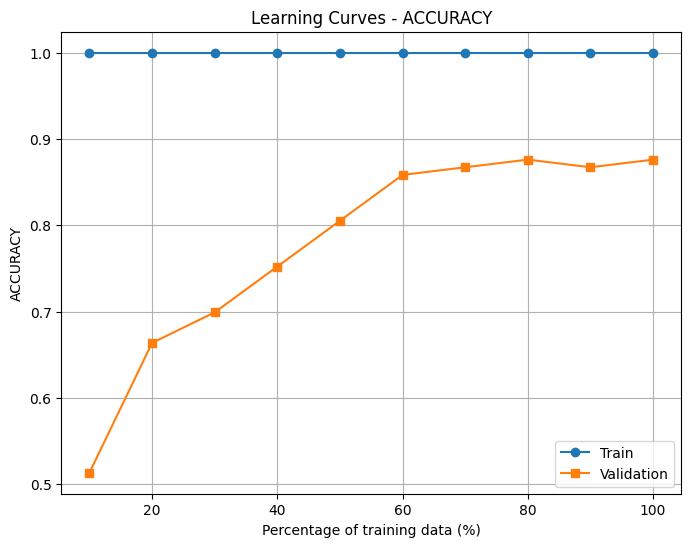

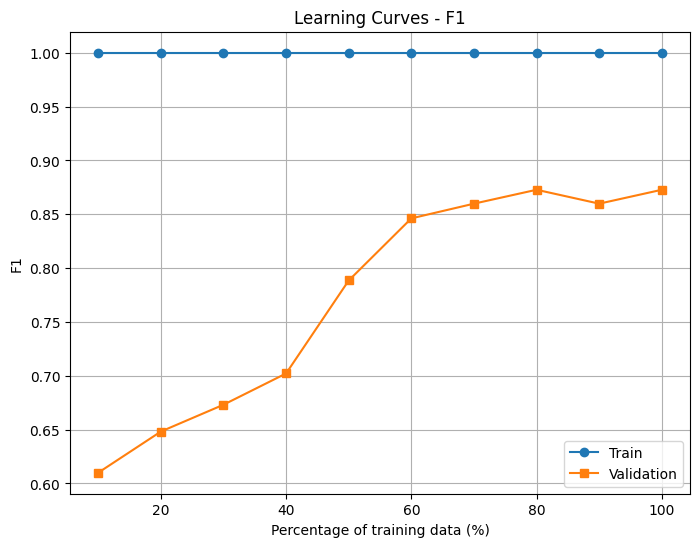

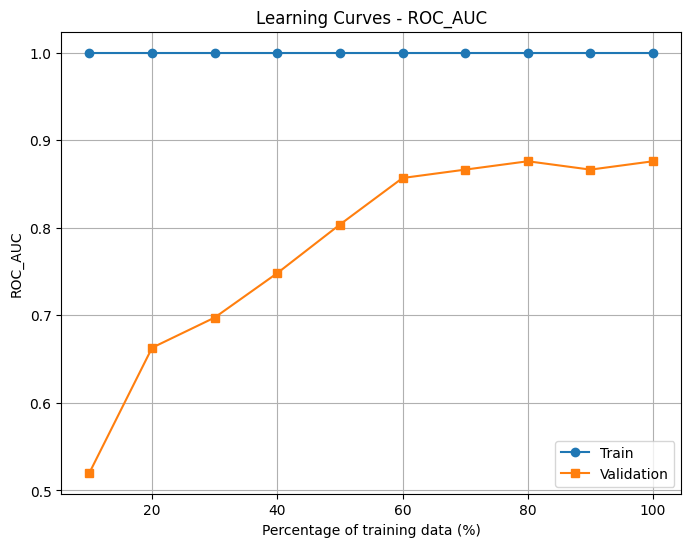

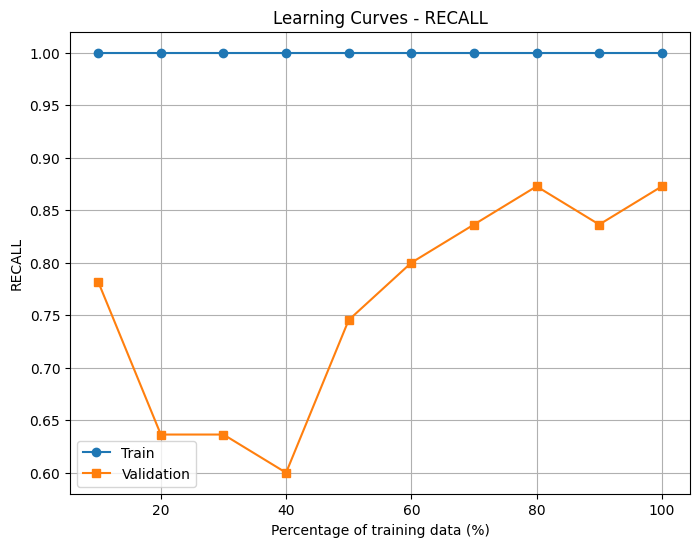

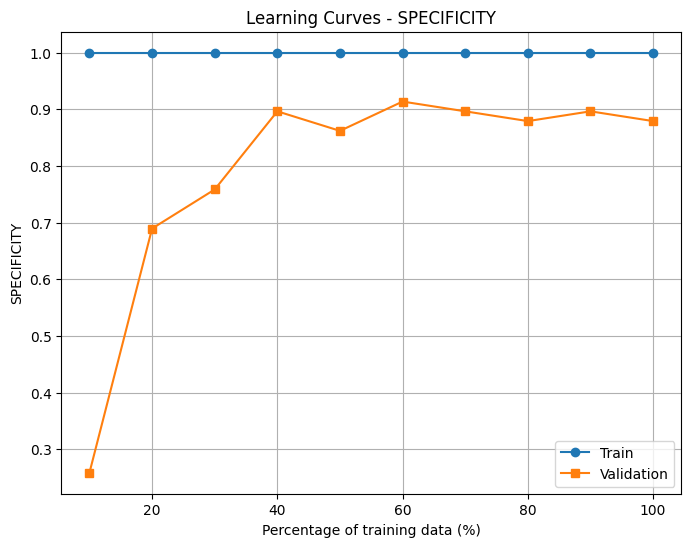

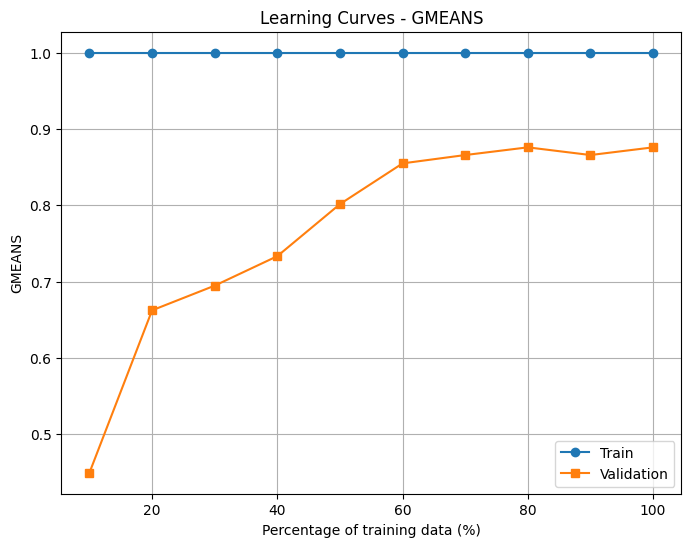

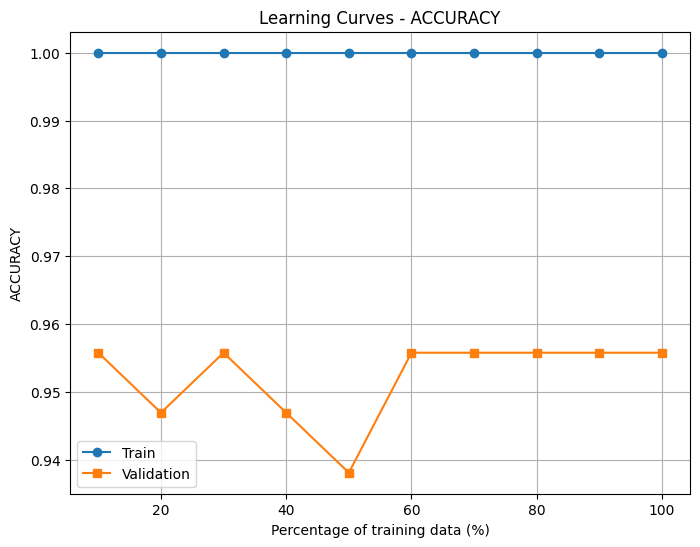

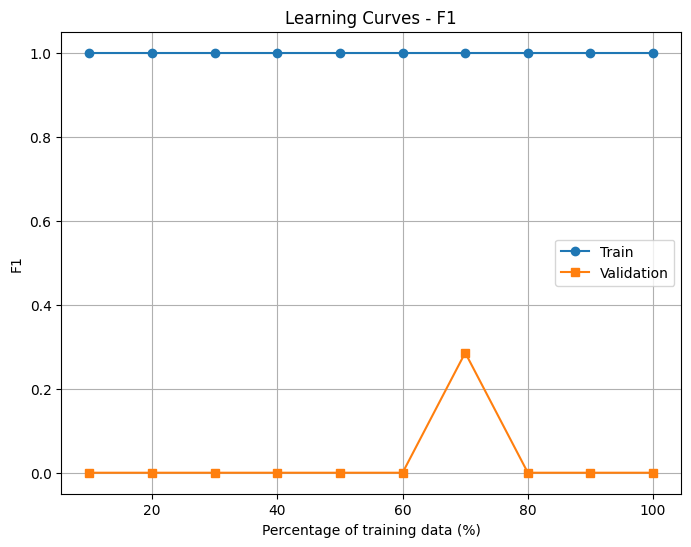

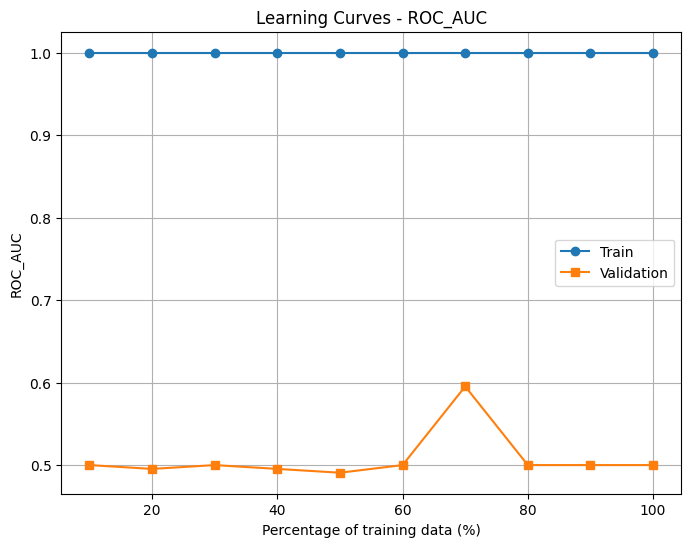

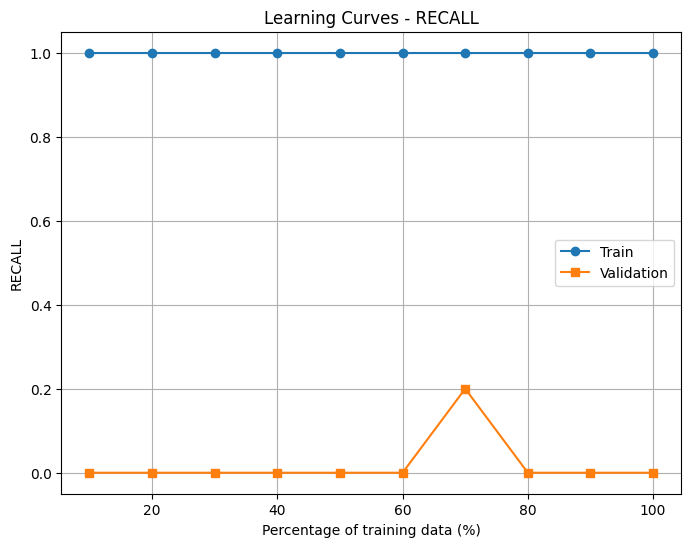

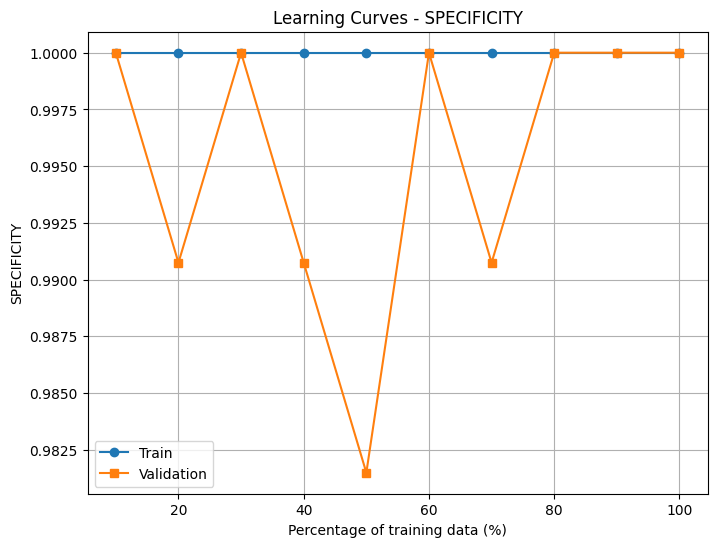

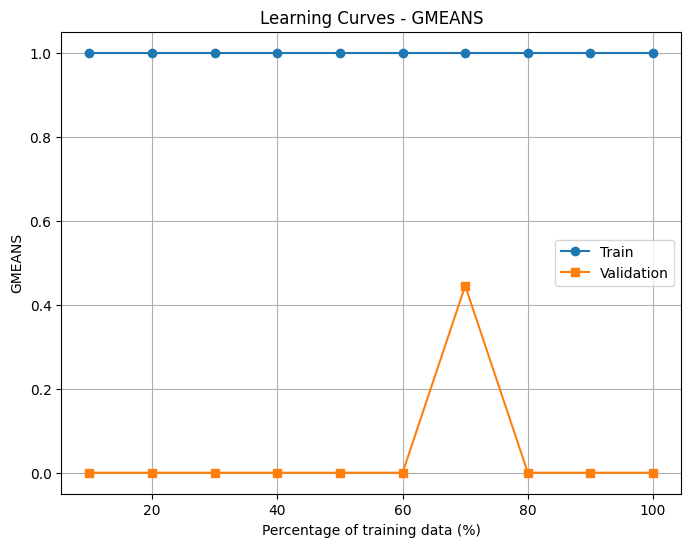

In [17]:
train_and_evaluate()

# Executar Algoritmo e Obter Dados

In [ ]:
"""
    Executa validação cruzada estratificada para múltiplos datasets em uma pasta, treinando
    um modelo Gradient Boosting e avaliando seu desempenho em cada fold. Por fim, agrega as
    métricas médias de cada dataset e salva em CSV.

    Objetivos:
    ----------
    - Avaliar modelos em datasets variados com classes desbalanceadas.
    - Preservar proporção das classes em cada fold usando StratifiedKFold.
    - Coletar métricas importantes: ROC AUC, Recall, Specificity e F1-score.
    - Salvar métricas agregadas para análise posterior.

    Passos principais:
    ------------------
    1. Para cada arquivo CSV na pasta 'folder_path':
        - Carregar o dataset.
        - Codificar colunas categóricas para valores numéricos com LabelEncoder.
        - Substituir rótulos -1 por 0 para padronização binária.
        - Separar features (X) e target (y).

    2. Para cada fold na validação cruzada estratificada (K=5):
        - Dividir dados em treino e teste mantendo a proporção das classes.
        - Imprimir distribuição de classes nos conjuntos de treino e teste.
        - Treinar um Gradient Boosting Classifier com parâmetros definidos.
        - Realizar predições e converter para classes binárias.
        - Calcular métricas: ROC AUC, Recall, Specificity e F1-score.
        - Armazenar métricas de cada fold.

    3. Após os folds, calcular a média das métricas por dataset.

    4. Salvar todas as métricas médias em um arquivo CSV nomeado 'output_csv'.

    Parâmetros e configurações:
    ---------------------------
    - n_splits=5 para StratifiedKFold.
    - GradientBoostingClassifier com n_estimators=50, max_depth=4, max_features=√(n_features), learning_rate=0.1.
    - Random state fixo para reprodutibilidade.

    Resultado:
    ----------
    Um CSV contendo métricas médias (ROC_AUC, Recall, Specificity, F1) para cada dataset processado,
    facilitando comparação de desempenho entre datasets com diferentes níveis de balanceamento.
    """

folder_path = "class_imbalance/"
output_csv = "relatorio_sem_mod.csv"
K = 5  
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=1111)

all_metrics = []

for filename in os.listdir(folder_path):
    # Carregar e pré-processar dataset
    df = pd.read_csv(os.path.join(folder_path, filename))
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:,-1].to_numpy()
    y = np.where(y == -1, 0, y)

    fold_metrics = []

    # Loop de cross-validation estratificada
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        # Distribuição de classes
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        print(f"\n[{filename}] Fold {fold_idx} – train dist: {dict(zip(unique_train, counts_train))}")
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        print(f"[{filename}] Fold {fold_idx} – test  dist: {dict(zip(unique_test, counts_test))}\n")

        # Treino do modelo
        model = GradientBoostingClassifier(
            n_estimators=50,
            max_depth=4,
            max_features=math.ceil(math.sqrt(X.shape[1])),
            learning_rate=0.1
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds = (preds >= 0.5).astype(int)

        # Métricas por fold
        roc_auc = roc_auc_score(y_test, preds)
        recall = recall_score(y_test, preds)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, preds)

        fold_metrics.append({
            'fold': fold_idx,
            'ROC_AUC': roc_auc,
            'Recall': recall,
            'Specificity': specificity,
            'F1': f1
        })

    # Agrega métricas dos folds
    df_fold = pd.DataFrame(fold_metrics)
    mean_metrics = df_fold.mean(numeric_only=True).to_dict()
    mean_metrics['DataSet'] = filename
    all_metrics.append(mean_metrics)

# Salvar métricas agregadas
metrics_df = pd.DataFrame(all_metrics)
columns = ['DataSet', 'ROC_AUC', 'Recall', 'Specificity', 'F1']
metrics_df = metrics_df[columns]
metrics_df.to_csv(output_csv, index=False)
print(f"All metrics (mean over {K} folds) saved to {output_csv}")


[dataset_1045_kc1-top5.csv] Fold 1 – train dist: {np.int64(0): np.int64(6), np.int64(1): np.int64(110)}
[dataset_1045_kc1-top5.csv] Fold 1 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}


[dataset_1045_kc1-top5.csv] Fold 2 – train dist: {np.int64(0): np.int64(6), np.int64(1): np.int64(110)}
[dataset_1045_kc1-top5.csv] Fold 2 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}


[dataset_1045_kc1-top5.csv] Fold 3 – train dist: {np.int64(0): np.int64(6), np.int64(1): np.int64(110)}
[dataset_1045_kc1-top5.csv] Fold 3 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}


[dataset_1045_kc1-top5.csv] Fold 4 – train dist: {np.int64(0): np.int64(7), np.int64(1): np.int64(109)}
[dataset_1045_kc1-top5.csv] Fold 4 – test  dist: {np.int64(0): np.int64(1), np.int64(1): np.int64(28)}


[dataset_1045_kc1-top5.csv] Fold 5 – train dist: {np.int64(0): np.int64(7), np.int64(1): np.int64(109)}
[dataset_1045_kc1-top5.csv] Fold 5 – test  dist: {np.int64(

# Analisar dados

**Métrica G-mean (Geometric Mean)**

A métrica **G-mean** (média geométrica) é utilizada para avaliar o desempenho de classificadores, especialmente em problemas de classificação binária **com dados desbalanceados**.

**Fórmula**:
$$\text{G-mean} = \sqrt{\text{Recall} \times \text{Specificity}}$$

- **Recall** (ou Sensibilidade): Proporção de positivos corretamente identificados.
- **Specificity** (ou Especificidade): Proporção de negativos corretamente identificados.

**Por que usar G-mean?**

Em datasets desbalanceados, a **accuracy** pode ser enganadora: um classificador que prevê sempre a classe maioritária pode ter alta **accuracy**, mas péssimo desempenho geral.

A G-mean penaliza modelos que têm bom desempenho só numa das classes. Ao combinar **recall** e **specificity**, promove classificadores que **equilibram bem** o desempenho entre classes positivas e negativas.


In [ ]:
# Carrega o dataset com modificações
df_nao_mod = pd.read_csv("relatorio_sem_mod.csv")
# Calcula a métrica G-mean a partir do recall e da specificity
df_nao_mod['G_means'] = np.sqrt(df_nao_mod['Recall'] * df_nao_mod['Specificity'])
df_nao_mod

,DataSet,ROC_AUC,Recall,Specificity,F1,G_means
0,dataset_1045_kc1-top5.csv,0.689021,0.978042,0.400000,0.971029,0.625473
1,dataset_312_scene.csv,0.907572,0.835392,0.979753,0.866557,0.904698
2,dataset_1059_ar1.csv,0.486364,0.000000,0.972727,0.000000,0.000000
3,dataset_1023_soybean.csv,0.938001,0.891228,0.984774,0.895504,0.936834
4,dataset_949_arsenic-female-bladder.csv,0.616535,0.920570,0.312500,0.904432,0.536356
5,dataset_1021_page-blocks.csv,0.947215,0.983715,0.910714,0.986725,0.946511
6,dataset_954_spectrometer.csv,0.905561,0.836364,0.974759,0.815455,0.902914
7,dataset_962_mfeat-morphological.csv,0.991944,0.985000,0.998889,0.987527,0.991920
8,dataset_980_optdigits.csv,0.963046,0.930053,0.996038,0.946599,0.962481
9,dataset_951_arsenic-male-lung.csv,1.000000,1.000000,1.000000,1.000000,1.000000


Identificação de Datasets com G-mean Baixo e G-mean Alto

Nesta etapa, separamos os datasets cuja métrica G-mean é inferior ou igual a **0.70** e os que têm **G-mean** superior a **0.70**

A G-mean varia entre 0 e 1, onde valores mais próximos de 1 indicam que o modelo está a conseguir equilibrar bem: o **recall** e a **specificity** 

Quando a G-mean é **≤ 0.70**, isso sugere que o modelo está a falhar significativamente **em pelo menos uma das classes**, o que é especialmente problemático em situações de **desbalanceamento**, onde já existe risco de ignorar a classe minoritária. Já  **G-mean > 0.70** sugere que o classificador tem um equilíbrio aceitável entre **recall** e **specificity**.



In [ ]:
# Filtra os datasets cujo G-means é considerado baixo (≤ 0.70)
df_abaixo = df_nao_mod[df_nao_mod['G_means'] <= 0.70]
# Mostra apenas os nomes dos datasets e os respetivos valores de G-means
df_abaixo[["DataSet","G_means"]]

,DataSet,G_means
0,dataset_1045_kc1-top5.csv,0.625473
2,dataset_1059_ar1.csv,0.000000
4,dataset_949_arsenic-female-bladder.csv,0.536356
13,dataset_984_analcatdata_draft.csv,0.383296
14,dataset_865_analcatdata_neavote.csv,0.000000
16,dataset_1061_ar4.csv,0.595627
18,dataset_1056_mc1.csv,0.567159
20,dataset_1050_pc3.csv,0.558472
21,dataset_1064_ar6.csv,0.494854
25,dataset_316_yeast_ml8.csv,0.000000


In [ ]:
# Filtra os datasets cujo G-mean é considerado aceitável ou bom (> 0.70)
df_acima = df_nao_mod[df_nao_mod['G_means'] > 0.70]
# Mostra apenas os nomes dos datasets e os respetivos valores de G-mean
df_acima[["DataSet","G_means"]]

,DataSet,G_means
1,dataset_312_scene.csv,0.904698
3,dataset_1023_soybean.csv,0.936834
5,dataset_1021_page-blocks.csv,0.946511
6,dataset_954_spectrometer.csv,0.902914
7,dataset_962_mfeat-morphological.csv,0.991920
8,dataset_980_optdigits.csv,0.962481
9,dataset_951_arsenic-male-lung.csv,1.000000
10,dataset_971_mfeat-fourier.csv,0.987421
11,dataset_940_water-treatment.csv,0.888763
12,dataset_978_mfeat-factors.csv,0.979524


**Inclusão da Coluna de Desbalanceamento de Classes**

Foi adicionada ao DataFrame uma nova coluna chamada **`imbal_ratio`**, que representa a **razão de desbalanceamento** entre as classes do dataset original. Essa razão é definida como:

$$\text{imbal\_ratio} = \frac{\text{número de exemplos da classe minoritária}}{\text{número de exemplos da classe maioritátia}}$$

In [ ]:
# Função que calcula a razão de desbalanceamento (minoria / maioria) de um dataset
def calc_imbal_ratio(path):
    sub = pd.read_csv(path)
    target_col = sub.columns[-1]  
    counts = sub[target_col].value_counts()
    minor = counts.min()
    major = counts.max()
    return minor / major

In [ ]:
# Calcula o desbalanceamento para cada dataset presente no relatório modificado
imbalance_vals = []
for fname in df_nao_mod['DataSet']:
    fullpath = os.path.join('class_imbalance', fname)
    imbalance_vals.append(calc_imbal_ratio(fullpath))
# Adiciona a nova coluna imbal_ratio ao DataFrame df_mod
df_nao_mod['imbal_ratio'] = imbalance_vals
df_nao_mod

,DataSet,ROC_AUC,Recall,Specificity,F1,G_means,imbal_ratio
0,dataset_1045_kc1-top5.csv,0.689021,0.978042,0.400000,0.971029,0.625473,0.058394
1,dataset_312_scene.csv,0.907572,0.835392,0.979753,0.866557,0.904698,0.218117
2,dataset_1059_ar1.csv,0.486364,0.000000,0.972727,0.000000,0.000000,0.080357
3,dataset_1023_soybean.csv,0.938001,0.891228,0.984774,0.895504,0.936834,0.155668
4,dataset_949_arsenic-female-bladder.csv,0.616535,0.920570,0.312500,0.904432,0.536356,0.167015
5,dataset_1021_page-blocks.csv,0.947215,0.983715,0.910714,0.986725,0.946511,0.113983
6,dataset_954_spectrometer.csv,0.905561,0.836364,0.974759,0.815455,0.902914,0.115546
7,dataset_962_mfeat-morphological.csv,0.991944,0.985000,0.998889,0.987527,0.991920,0.111111
8,dataset_980_optdigits.csv,0.963046,0.930053,0.996038,0.946599,0.962481,0.113312
9,dataset_951_arsenic-male-lung.csv,1.000000,1.000000,1.000000,1.000000,1.000000,0.023810


In [ ]:
def get_minority_class(caminho):
    """
    Identifica a classe minoritária (menos frequente) no dataset dado pelo caminho.

    Parâmetros:
    -----------
    caminho : str
        Caminho para o arquivo CSV do dataset.

    Retorna:
    --------
    menos_frequente : int
        Valor da classe minoritária na coluna target (última coluna do dataset).

    Objetivo:
    --------

    Para cada arquivo no diretório, identifica a classe minoritária e
    atribui uma métrica específica (recall ou specificity) à coluna metric_minority
    em um DataFrame df_nao_mod, baseado no valor da classe minoritária.

    Processo:
    ---------
    - Lê o dataset CSV.
    - Identifica a última coluna como a coluna target.
    - Codifica colunas categóricas (objetos) em valores numéricos usando LabelEncoder.
    - Conta as ocorrências de cada classe na coluna target.
    - Retorna a classe com menor número de exemplos.
    """

    # Ler o dataset
    df = pd.read_csv(caminho)
    # Identificar a coluna target 
    target_col = df.columns[-1]
    
    # Codificar colunas não numéricas 
    label_encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    
    # Contar as ocorrências de cada classe da target
    class_counts = df[target_col].value_counts()

    # Obter a classe menos frequente
    menos_frequente = class_counts.idxmin()
    
    return menos_frequente

In [ ]:
folder_path = "class_imbalance/"
for i, fname in enumerate(os.listdir(folder_path)):
    minority_class = get_minority_class(os.path.join(folder_path, fname))
    # Se a classe minoritária for 1, escolhe "recall" como métrica prioritária, caso contrário, escolhe "specificity".
    if minority_class == 1:
        df_nao_mod.loc[i, "metric_minority"] = "recall"
    else:
        df_nao_mod.loc[i, "metric_minority"] = "specificity"

df_nao_mod

,DataSet,ROC_AUC,Recall,Specificity,F1,G_means,imbal_ratio,metric_minority
0,dataset_1045_kc1-top5.csv,0.689021,0.978042,0.400000,0.971029,0.625473,0.058394,specificity
1,dataset_312_scene.csv,0.907572,0.835392,0.979753,0.866557,0.904698,0.218117,recall
2,dataset_1059_ar1.csv,0.486364,0.000000,0.972727,0.000000,0.000000,0.080357,recall
3,dataset_1023_soybean.csv,0.938001,0.891228,0.984774,0.895504,0.936834,0.155668,recall
4,dataset_949_arsenic-female-bladder.csv,0.616535,0.920570,0.312500,0.904432,0.536356,0.167015,specificity
5,dataset_1021_page-blocks.csv,0.947215,0.983715,0.910714,0.986725,0.946511,0.113983,specificity
6,dataset_954_spectrometer.csv,0.905561,0.836364,0.974759,0.815455,0.902914,0.115546,recall
7,dataset_962_mfeat-morphological.csv,0.991944,0.985000,0.998889,0.987527,0.991920,0.111111,recall
8,dataset_980_optdigits.csv,0.963046,0.930053,0.996038,0.946599,0.962481,0.113312,recall
9,dataset_951_arsenic-male-lung.csv,1.000000,1.000000,1.000000,1.000000,1.000000,0.023810,specificity


In [57]:
df_nao_mod.to_csv("relatorio_sem_mod_Gmean.csv", index=False)